# Projeto de Previsão de Churn

## Objetivo
- Prever quais clientes têm maior possibilidade de cancelar o serviço dentro dos proximos meses.

## Dataset
- **Fonte**: Telco Customer Churn (Kaggle)

# Modelos
1. **Regressão Logística**
2. **Gradient Boosting** 

## Ordem
# 1. Data Loading
# 2. Data Understanding
# 2. Data Cleaning
# 4. Exploratory Data
# 5. Statistical Tests
# 6. Feature Preparation
# 7. Modeling
# 8. Visualization
# 9. Conclusion

# 1. Data Loading
- Carregar os dados 

In [1]:
# Importar bibliotecas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency, ttest_ind
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import warnings
warnings.filterwarnings('ignore')

# Configurar visualizações
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print(" Bibliotecas carregadas com sucesso!")

 Bibliotecas carregadas com sucesso!


In [9]:
# Aumentar limite de exibição do pandas
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', None)

# Carregar dataset
df = pd.read_csv('../data/raw/churn.csv')

# Exibir primeiras linhas
print(" Primeiras linhas do dataset:")
print(df.head())

print(f"\n Dimensões: {df.shape[0]} linhas × {df.shape[1]} colunas")

 Primeiras linhas do dataset:
   customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity OnlineBackup  \
0  No phone service             DSL             No          Yes   
1                No             DSL            Yes           No   
2                No             DSL            Yes          Yes   
3  No phone service             DSL            Yes           No   
4                No     Fiber optic             No           No   

  DeviceProtection TechSupport StreamingTV StreamingMovies        Contract  \
0       

In [7]:
# Aumentar limite de exibição do pandas
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', None)

# Informações sobre o dataset
print("Tipos de dados e valores nulos:")
print(df.info())

print("\nResumo estatístico:")
print(df.describe())

Tipos de dados e valores nulos:
<class 'pandas.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   str    
 1   gender            7043 non-null   str    
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   str    
 4   Dependents        7043 non-null   str    
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   str    
 7   MultipleLines     7043 non-null   str    
 8   InternetService   7043 non-null   str    
 9   OnlineSecurity    7043 non-null   str    
 10  OnlineBackup      7043 non-null   str    
 11  DeviceProtection  7043 non-null   str    
 12  TechSupport       7043 non-null   str    
 13  StreamingTV       7043 non-null   str    
 14  StreamingMovies   7043 non-null   str    
 15  Contract          7043 non-null   str    
 16  PaperlessBilling  704

# 2. Data Understanding
- Verificação dos dados: tipos, distribuição, valores únicos

In [10]:
# Separação de variáveis numéricas e categóricas
colunas_numericas = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
colunas_categoricas = df.select_dtypes(include=['object']).columns.tolist()

print(f"Variáveis numéricas ({len(colunas_numericas)}):")
print(colunas_numericas)

print(f"\nVariáveis categóricas ({len(colunas_categoricas)}):")
print(colunas_categoricas)

Variáveis numéricas (3):
['SeniorCitizen', 'tenure', 'MonthlyCharges']

Variáveis categóricas (18):
['customerID', 'gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'TotalCharges', 'Churn']


In [11]:
# Verificar valores nulos
print("Valores nulos por coluna:")
nulos = df.isnull().sum()
print(nulos[nulos > 0])

if nulos.sum() == 0:
    print("Nenhum valor nulo encontrado!")

Valores nulos por coluna:
Series([], dtype: int64)
Nenhum valor nulo encontrado!


## Observações sobre os dados

Analisando a estrutura do dataset:

- **3 variáveis numéricas**: SeniorCitizen, tenure, MonthlyCharges
  - Essas são as únicas com valores números contínuos ou inteiros
  
- **18 variáveis categóricas**: Incluindo a nossa variável alvo "Churn"
  - Bastante variáveis categóricas, teremos que fazer conversão para os modelos
  - A coluna "TotalCharges" aparece como categórica, provavelmente tem valores texto
  - Vai precisar revisar essa coluna depois
  
- **Sem valores nulos**: Bom sinal, não precisamos fazer imputação de dados faltantes
  
- **Próximo passo**: Limpar a coluna TotalCharges e verificar se tem algo estranho

# 3. Data Cleaning

- Correção dos problemas nos dados, converter tipos e preparar para análise.

In [12]:
# Verificar a coluna TotalCharges 
# Analisar valores e entender o problema
print("Amostra de valores em TotalCharges:")
print(df['TotalCharges'].head(20))

print("\nTipo de dado:")
print(df['TotalCharges'].dtype)

# Medir valores únicos que podem ser discrepantes
print("\nValores únicos (primeiros 20):")
print(df['TotalCharges'].unique()[:20])

Amostra de valores em TotalCharges:
0       29.85
1      1889.5
2      108.15
3     1840.75
4      151.65
5       820.5
6      1949.4
7       301.9
8     3046.05
9     3487.95
10     587.45
11      326.8
12     5681.1
13     5036.3
14    2686.05
15    7895.15
16    1022.95
17    7382.25
18     528.35
19     1862.9
Name: TotalCharges, dtype: str

Tipo de dado:
str

Valores únicos (primeiros 20):
<StringArray>
[  '29.85',  '1889.5',  '108.15', '1840.75',  '151.65',   '820.5',  '1949.4',
   '301.9', '3046.05', '3487.95',  '587.45',   '326.8',  '5681.1',  '5036.3',
 '2686.05', '7895.15', '1022.95', '7382.25',  '528.35',  '1862.9']
Length: 20, dtype: str


## Observação
- Foi detectado que TotalCharges esta em formato de texto e deveria ser em número seu formato.

In [13]:
# Converter TotalCharges de texto para número
# Verificar se possui valores vazios ou estranhos
print("Valores únicos que são diferentes de números:")
valores_unicos = df['TotalCharges'].unique()
for valor in valores_unicos:
    try:
        float(valor)
    except:
        print(f"  - '{valor}'")

Valores únicos que são diferentes de números:
  - ' '


In [14]:
# Converter TotalCharges para número
# Substituir valores encontrados por NaN primeiro
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

# Ver quantos valores ficaram como NaN
print(f"Valores inválidos convertidos para NaN: {df['TotalCharges'].isnull().sum()}")

print("\nPrimeiras linhas após conversão:")
print(df[['tenure', 'MonthlyCharges', 'TotalCharges']].head(10))

print("\nTipo de dado agora:")
print(df['TotalCharges'].dtype)

Valores inválidos convertidos para NaN: 11

Primeiras linhas após conversão:
   tenure  MonthlyCharges  TotalCharges
0       1           29.85         29.85
1      34           56.95       1889.50
2       2           53.85        108.15
3      45           42.30       1840.75
4       2           70.70        151.65
5       8           99.65        820.50
6      22           89.10       1949.40
7      10           29.75        301.90
8      28          104.80       3046.05
9      62           56.15       3487.95

Tipo de dado agora:
float64


## Valores faltantes em TotalCharges

- A descoberta acarretou em  11 linhas com valores inválidos (espaços em branco) em TotalCharges.

Opções para resolver:
- **Remover as linhas** - Perde 11 registros mas fica limpo
- **Preencher com a mediana** - Mantém os 11 registros com valor estimado

- Foi removida as linhas porque são poucos registros (11 de 7043 = 0.15%).

In [15]:
# Antes da limpeza
print(f"Total de linhas antes: {df.shape[0]}")

# Remover linhas onde TotalCharges é NaN
df = df.dropna(subset=['TotalCharges'])

# Depois da limpeza
print(f"Total de linhas após remover NaN: {df.shape[0]}")
print(f"Linhas removidas: 11")

# Verificar se resolveu
print(f"\nValores nulos agora: {df['TotalCharges'].isnull().sum()}")

Total de linhas antes: 7043
Total de linhas após remover NaN: 7032
Linhas removidas: 11

Valores nulos agora: 0


In [16]:
# Definição da variável Churn (alvo)
print("Valores únicos em Churn:")
print(df['Churn'].unique())

print("\nDistribuição de Churn:")
print(df['Churn'].value_counts())

print("\nPercentual:")
print(df['Churn'].value_counts(normalize=True) * 100)

Valores únicos em Churn:
<StringArray>
['No', 'Yes']
Length: 2, dtype: str

Distribuição de Churn:
Churn
No     5163
Yes    1869
Name: count, dtype: int64

Percentual:
Churn
No     73.421502
Yes    26.578498
Name: proportion, dtype: float64


## Análise da variável alvo (Churn)

- **Sem Churn (No)**: 5.163 clientes (73,4%)
- **Com Churn (Yes)**: 1.869 clientes (26,6%)

É possivel observar um desbalanceamento natural, mas não é crítico para o modelo.
A maioria dos clientes não cancela, o que é esperado em um negócio saudável.

In [17]:
# Variáveis categóricas (exceto customerID que não usamos)
# Converter em Yes/No em 1/0
colunas_sim_nao = ['Partner', 'Dependents', 'PhoneService', 'OnlineSecurity', 
                   'OnlineBackup', 'DeviceProtection', 'TechSupport', 
                   'StreamingTV', 'StreamingMovies', 'PaperlessBilling', 'Churn']

for coluna in colunas_sim_nao:
    df[coluna] = df[coluna].map({'Yes': 1, 'No': 0})

print("Colunas convertidas (Yes/No -> 1/0):")
print(df[colunas_sim_nao].head())

Colunas convertidas (Yes/No -> 1/0):
   Partner  Dependents  PhoneService  OnlineSecurity  OnlineBackup  \
0        1           0             0             0.0           1.0   
1        0           0             1             1.0           0.0   
2        0           0             1             1.0           1.0   
3        0           0             0             1.0           0.0   
4        0           0             1             0.0           0.0   

   DeviceProtection  TechSupport  StreamingTV  StreamingMovies  \
0               0.0          0.0          0.0              0.0   
1               1.0          0.0          0.0              0.0   
2               0.0          0.0          0.0              0.0   
3               1.0          1.0          0.0              0.0   
4               0.0          0.0          0.0              0.0   

   PaperlessBilling  Churn  
0                 1      0  
1                 0      0  
2                 1      1  
3                 0      0  


In [18]:
# Converter gender em número
df['gender'] = df['gender'].map({'Male': 1, 'Female': 0})

# Converter MultipleLines (tem 3 valores)
print("Valores em MultipleLines:")
print(df['MultipleLines'].unique())

# Converter MultipleLines
df['MultipleLines'] = df['MultipleLines'].map({'Yes': 1, 'No': 0, 'No phone service': 2})

print("\nMultipleLines após conversão:")
print(df['MultipleLines'].unique())

Valores em MultipleLines:
<StringArray>
['No phone service', 'No', 'Yes']
Length: 3, dtype: str

MultipleLines após conversão:
[2 0 1]


## 3.1 Tratamento e conversão de categorias

In [19]:
# Verificar as variáveis com múltiplas categorias
print("Valores em InternetService:")
print(df['InternetService'].unique())

print("\nValores em Contract:")
print(df['Contract'].unique())

print("\nValores em PaymentMethod:")
print(df['PaymentMethod'].unique())

Valores em InternetService:
<StringArray>
['DSL', 'Fiber optic', 'No']
Length: 3, dtype: str

Valores em Contract:
<StringArray>
['Month-to-month', 'One year', 'Two year']
Length: 3, dtype: str

Valores em PaymentMethod:
<StringArray>
[         'Electronic check',              'Mailed check',
 'Bank transfer (automatic)',   'Credit card (automatic)']
Length: 4, dtype: str


In [20]:
# Converter as variáveis categóricas usando one-hot encoding
# Isso cria colunas para cada categoria

# Variáveis que vão receber one-hot encoding
colunas_encode = ['InternetService', 'Contract', 'PaymentMethod']

# Fazer one-hot encoding
df_encoded = pd.get_dummies(df, columns=colunas_encode, drop_first=True)

print("Colunas após one-hot encoding:")
print(df_encoded.columns.tolist())

print(f"\nTotal de colunas agora: {df_encoded.shape[1]}")

# Remover colunas que não precisamos mais
df_encoded = df_encoded.drop(['customerID'], axis=1)

print(f"Após remover customerID: {df_encoded.shape[1]} colunas")

Colunas após one-hot encoding:
['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'PhoneService', 'MultipleLines', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'PaperlessBilling', 'MonthlyCharges', 'TotalCharges', 'Churn', 'InternetService_Fiber optic', 'InternetService_No', 'Contract_One year', 'Contract_Two year', 'PaymentMethod_Credit card (automatic)', 'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check']

Total de colunas agora: 25
Após remover customerID: 24 colunas


## Tratamento de variáveis categóricas

Converter em variáveis categóricas:
- **Yes/No** em 1/0 (11 colunas)
- **Gender** em 1/0
- **MultipleLines** em 0, 1, 2 (3 categorias)
- **InternetService, Contract, PaymentMethod** em colunas binárias (one-hot encoding)

- Removemos customerID porque não adiciona informação, temos apenas variáveis numéricas prontas para os modelos.

In [42]:
## Observação:
# Salvar dataset limpo e processado
df.to_csv('../data/processed/churn_processed.csv', index=False)

print("Dataset processado salvo em: data/processed/churn_processed.csv")
print(f"Total de linhas: {df.shape[0]}")
print(f"Total de colunas: {df.shape[1]}")

Dataset processado salvo em: data/processed/churn_processed.csv
Total de linhas: 7032
Total de colunas: 24


# 4. Exploratory Data Analysis

Análise dos dados para entender padrões e relações entre variáveis.

In [21]:
# Usar df_encoded daqui em diante
df = df_encoded.copy()

# Resumo estatístico das variáveis numéricas
print("Resumo estatístico:")
print(df.describe())

Resumo estatístico:
            gender  SeniorCitizen      Partner   Dependents       tenure  \
count  7032.000000    7032.000000  7032.000000  7032.000000  7032.000000   
mean      0.504693       0.162400     0.482509     0.298493    32.421786   
std       0.500014       0.368844     0.499729     0.457629    24.545260   
min       0.000000       0.000000     0.000000     0.000000     1.000000   
25%       0.000000       0.000000     0.000000     0.000000     9.000000   
50%       1.000000       0.000000     0.000000     0.000000    29.000000   
75%       1.000000       0.000000     1.000000     1.000000    55.000000   
max       1.000000       1.000000     1.000000     1.000000    72.000000   

       PhoneService  MultipleLines  OnlineSecurity  OnlineBackup  \
count   7032.000000    7032.000000     5512.000000   5512.000000   
mean       0.903299       0.615330        0.365566      0.439949   
std        0.295571       0.655867        0.481632      0.496426   
min        0.000000    

In [22]:
# Correlação com a variável alvo (Churn)
# Qual variável tem mais relação com cancelamento?

correlacao_churn = df.corr()['Churn'].sort_values(ascending=False)

print("Correlação com Churn (do maior para menor):")
print(correlacao_churn)

print("\nVariáveis com maior relação positiva com Churn:")
print(correlacao_churn[correlacao_churn > 0.1])

print("\nVariáveis com maior relação negativa com Churn:")
print(correlacao_churn[correlacao_churn < -0.1])

Correlação com Churn (do maior para menor):
Churn                                    1.000000
InternetService_Fiber optic              0.307463
PaymentMethod_Electronic check           0.301455
MonthlyCharges                           0.192858
PaperlessBilling                         0.191454
SeniorCitizen                            0.150541
MultipleLines                            0.019609
PhoneService                             0.011691
gender                                  -0.008545
StreamingTV                             -0.036698
StreamingMovies                         -0.040525
PaymentMethod_Mailed check              -0.090773
PaymentMethod_Credit card (automatic)   -0.134687
Partner                                 -0.149982
Dependents                              -0.163128
DeviceProtection                        -0.176806
Contract_One year                       -0.178225
OnlineBackup                            -0.195758
TotalCharges                            -0.199484
Intern

## Resultados
- As variáveis que tem maior impacto em nossos cancelamentos:
*tenure (duração em meses)*: -0.354 - Quem fica mais tempo não cancela
*Contract_Two year*: -0.301 - Contrato de 2 anos reduz cancelamento
*OnlineSecurity*: -0.280 - Quem tem segurança online cancela menos
*TechSupport*: -0.274 - Quem tem suporte técnico cancela menos
*InternetService_Fiber optic*: +0.307 - Fibra óptica aumenta cancelamento
*PaymentMethod_Electronic check*: +0.301 - Pagamento por cheque eletrônico aumenta cancelamento

# 5. Statistical Tests

- Será aplicado testes estatísticos para confirmar relações entre variáveis e churn.

In [23]:
# Teste Qui-Quadrado: Contract tem relação com Churn?
from scipy.stats import chi2_contingency

# Criar tabela cruzada
tabela = pd.crosstab(df['Contract_One year'], df['Churn'])
chi2, p_value, dof, expected = chi2_contingency(tabela)

print("Teste Qui-Quadrado: Contract vs Churn")
print(f"Chi-square: {chi2:.4f}")
print(f"P-value: {p_value:.6f}")
print(f"Resultado: Há relação estatística entre Contract e Churn" if p_value < 0.05 else "Sem relação significativa")

Teste Qui-Quadrado: Contract vs Churn
Chi-square: 222.3750
P-value: 0.000000
Resultado: Há relação estatística entre Contract e Churn


## Observação
- Confirmação da correlção, o contract tem relação com o Churn

In [24]:
# Teste t de Student: MonthlyCharges é diferente entre quem cancela vs quem fica?
from scipy.stats import ttest_ind

# Separar grupos
grupo_cancela = df[df['Churn'] == 1]['MonthlyCharges']
grupo_fica = df[df['Churn'] == 0]['MonthlyCharges']

# Fazer o teste
t_stat, p_value = ttest_ind(grupo_cancela, grupo_fica)

print("Teste t: MonthlyCharges - Quem cancela vs Quem fica")
print(f"Média de quem cancela: {grupo_cancela.mean():.2f}")
print(f"Média de quem fica: {grupo_fica.mean():.2f}")
print(f"T-statistic: {t_stat:.4f}")
print(f"P-value: {p_value:.6f}")
print(f"Resultado: Diferença significativa entre os grupos" if p_value < 0.05 else "Sem diferença significativa")

Teste t: MonthlyCharges - Quem cancela vs Quem fica
Média de quem cancela: 74.44
Média de quem fica: 61.31
T-statistic: 16.4796
P-value: 0.000000
Resultado: Diferença significativa entre os grupos


## Resumo dos testes estatísticos

**Teste Qui-Quadrado (Contract vs Churn):**
- P-value < 0.001 confirma que o tipo de contrato tem relação com cancelamento
- Contrato de 2 anos protege contra churn

**Teste t (MonthlyCharges):**
- Quem cancela paga em média R$ 74,44
- Quem fica paga em média R$ 61,31
- Diferença de R$ 13,13 (22% a mais)
- P-value < 0.001 confirma que essa diferença é real e não por acaso

**Conclusão**: Clientes com custos altos e contratos curtos tendem a cancelar mais.

# 6. Feature Preparation
- Preparação dos dados para treinar os modelos, separando features da variável alvo e normalizar

In [25]:
# Separar features (X) e alvo (y)
X = df.drop('Churn', axis=1)
y = df['Churn']

print(f"Features (X): {X.shape}")
print(f"Alvo (y): {y.shape}")

# Dividir em treino (80%) e teste (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"\nTreino: {X_train.shape[0]} amostras")
print(f"Teste: {X_test.shape[0]} amostras")

Features (X): (7032, 23)
Alvo (y): (7032,)

Treino: 5625 amostras
Teste: 1407 amostras


In [26]:
# Normalizar os dados
# Algumas variáveis têm escalas diferentes (tenure de 1-72, MonthlyCharges de 0-118)
# Normalizar deixa tudo na mesma escala

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Converter para DataFrame para facilitar
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

print("Dados normalizados (primeiras linhas):")
print(X_train_scaled.head())

print(f"\nForma de X_train_scaled: {X_train_scaled.shape}")
print(f"Forma de X_test_scaled: {X_test_scaled.shape}")

Dados normalizados (primeiras linhas):
     gender  SeniorCitizen   Partner  Dependents    tenure  PhoneService  \
0 -1.013784       -0.43759 -0.962481   -0.653684  0.434674     -3.040707   
1  0.986404       -0.43759 -0.962481   -0.653684 -1.195652      0.328871   
2 -1.013784       -0.43759  1.038981   -0.653684  0.923772      0.328871   
3  0.986404       -0.43759  1.038981    1.529791  0.516190      0.328871   
4 -1.013784       -0.43759  1.038981    1.529791  0.923772      0.328871   

   MultipleLines  OnlineSecurity  OnlineBackup  DeviceProtection  TechSupport  \
0       2.110087       -0.763350     -0.893191          1.130490    -0.768214   
1      -0.930579       -0.763350     -0.893191         -0.884572    -0.768214   
2       0.589754       -0.763350     -0.893191          1.130490    -0.768214   
3      -0.930579        1.310016     -0.893191         -0.884572     1.301721   
4       0.589754        1.310016     -0.893191         -0.884572    -0.768214   

   StreamingTV  S

## Preparado os dados

Temos agora:
- **X_train_scaled**: 5.625 amostras para treino (normalizado)
- **X_test_scaled**: 1.407 amostras para teste (normalizado)
- **y_train**: 5.625 labels para treino
- **y_test**: 1.407 labels para teste

# 7. Modeling

- Treinamento de dois modelos para prever churn:
1. Regressão Logística 
2. Gradient Boosting 

In [27]:
# Modelo 1: Regressão Logística

modelo_lr = LogisticRegression(random_state=42, max_iter=1000)
modelo_lr.fit(X_train_scaled, y_train)

# Fazer predições
y_pred_lr = modelo_lr.predict(X_test_scaled)
y_pred_proba_lr = modelo_lr.predict_proba(X_test_scaled)[:, 1]

print("Regressão Logística treinada!")
print(f"Acurácia no teste: {modelo_lr.score(X_test_scaled, y_test):.4f}")

ValueError: Input X contains NaN.
LogisticRegression does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [28]:
# Modelo 2: Gradient Boosting
# Modelo mais complexo, geralmente mais preciso

modelo_gb = GradientBoostingClassifier(random_state=42, n_estimators=100, learning_rate=0.1)
modelo_gb.fit(X_train_scaled, y_train)

# Fazer predições
y_pred_gb = modelo_gb.predict(X_test_scaled)
y_pred_proba_gb = modelo_gb.predict_proba(X_test_scaled)[:, 1]

print("Gradient Boosting treinado!")
print(f"Acurácia no teste: {modelo_gb.score(X_test_scaled, y_test):.4f}")

ValueError: Input X contains NaN.
GradientBoostingClassifier does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

## Observação
- Foi constatado que ainda há valores com NaN no dados, irei verificar e remover e rodar novamente.

In [29]:
# Verificar onde estão os NaN
print("Valores NaN em X_train_scaled:")
print(X_train_scaled.isnull().sum())

print("\nValores NaN em X_test_scaled:")
print(X_test_scaled.isnull().sum())

Valores NaN em X_train_scaled:
gender                                      0
SeniorCitizen                               0
Partner                                     0
Dependents                                  0
tenure                                      0
PhoneService                                0
MultipleLines                               0
OnlineSecurity                           1233
OnlineBackup                             1233
DeviceProtection                         1233
TechSupport                              1233
StreamingTV                              1233
StreamingMovies                          1233
PaperlessBilling                            0
MonthlyCharges                              0
TotalCharges                                0
InternetService_Fiber optic                 0
InternetService_No                          0
Contract_One year                           0
Contract_Two year                           0
PaymentMethod_Credit card (automatic)       0
Pay

# Observação 
- A maior possibilidade seria as colunas que tem NaN são serviços de internet, ja que quem nao possui internet(InternetService_No), não tem esses serviços e devem ter ficado vazios.

In [30]:
# Preencher NaN com 0 (não tem o serviço)
colunas_com_nan = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 
                   'TechSupport', 'StreamingTV', 'StreamingMovies']

X_train_scaled[colunas_com_nan] = X_train_scaled[colunas_com_nan].fillna(0)
X_test_scaled[colunas_com_nan] = X_test_scaled[colunas_com_nan].fillna(0)

# Verificar se resolveu
print("NaN após preenchimento:")
print(X_train_scaled.isnull().sum().sum())
print(X_test_scaled.isnull().sum().sum())

NaN após preenchimento:
0
0


In [31]:
## 2 Tentativa para treinar o modelo
# Modelo 1: Regressão Logística
modelo_lr = LogisticRegression(random_state=42, max_iter=1000)
modelo_lr.fit(X_train_scaled, y_train)

y_pred_lr = modelo_lr.predict(X_test_scaled)
y_pred_proba_lr = modelo_lr.predict_proba(X_test_scaled)[:, 1]

print("Regressão Logística treinada!")
print(f"Acurácia no teste: {modelo_lr.score(X_test_scaled, y_test):.4f}")

Regressão Logística treinada!
Acurácia no teste: 0.7882


In [32]:
# Modelo 2: Gradient Boosting
modelo_gb = GradientBoostingClassifier(random_state=42, n_estimators=100, learning_rate=0.1)
modelo_gb.fit(X_train_scaled, y_train)

y_pred_gb = modelo_gb.predict(X_test_scaled)
y_pred_proba_gb = modelo_gb.predict_proba(X_test_scaled)[:, 1]

print("Gradient Boosting treinado!")
print(f"Acurácia no teste: {modelo_gb.score(X_test_scaled, y_test):.4f}")

Gradient Boosting treinado!
Acurácia no teste: 0.7932


## 7.1 Teste para aprimoramento
- Apesar dos dados desbalanceados de 73/27, os modelos estão viciados em prever "não churn".

In [33]:
# Treinar Gradient Boosting com mais estimadores
modelo_gb_melhorado = GradientBoostingClassifier(
    random_state=42, 
    n_estimators=200,  # Aumentar de 100 para 200
    learning_rate=0.05,  # Diminuir para convergir melhor
    max_depth=5,  # Profundidade das árvores
    min_samples_split=20
)

modelo_gb_melhorado.fit(X_train_scaled, y_train)

y_pred_gb_melhorado = modelo_gb_melhorado.predict(X_test_scaled)
y_pred_proba_gb_melhorado = modelo_gb_melhorado.predict_proba(X_test_scaled)[:, 1]

print("Gradient Boosting Melhorado:")
print(f"Acurácia: {modelo_gb_melhorado.score(X_test_scaled, y_test):.4f}")
print(f"ROC-AUC: {roc_auc_score(y_test, y_pred_proba_gb_melhorado):.4f}")

Gradient Boosting Melhorado:
Acurácia: 0.7939
ROC-AUC: 0.8325


In [34]:
# Melhorar Regressão Logística com class_weight
modelo_lr_melhorado = LogisticRegression(
    random_state=42, 
    max_iter=1000,
    class_weight='balanced',  # Penalizar mais a classe minoritária (Churn)
    C=0.5  # Regularização
)

modelo_lr_melhorado.fit(X_train_scaled, y_train)

y_pred_lr_mel = modelo_lr_melhorado.predict(X_test_scaled)
y_pred_proba_lr_mel = modelo_lr_melhorado.predict_proba(X_test_scaled)[:, 1]

print("Regressão Logística Melhorada:")
print(f"Acurácia: {modelo_lr_melhorado.score(X_test_scaled, y_test):.4f}")
print(f"ROC-AUC: {roc_auc_score(y_test, y_pred_proba_lr_mel):.4f}")

print("\nRelatório detalhado:")
print(classification_report(y_test, y_pred_lr_mel))

Regressão Logística Melhorada:
Acurácia: 0.7321
ROC-AUC: 0.8316

Relatório detalhado:
              precision    recall  f1-score   support

           0       0.90      0.71      0.80      1033
           1       0.50      0.79      0.61       374

    accuracy                           0.73      1407
   macro avg       0.70      0.75      0.70      1407
weighted avg       0.80      0.73      0.75      1407



In [35]:
# Comparação final
print("=== COMPARAÇÃO FINAL ===\n")

print("REGRESSÃO LOGÍSTICA MELHORADA:")
print(f"Acurácia: {modelo_lr_melhorado.score(X_test_scaled, y_test):.4f}")
print(f"ROC-AUC: {roc_auc_score(y_test, y_pred_proba_lr_mel):.4f}")
print(f"Recall (Churn): {0.79:.2f}")

print("\nGRADIENT BOOSTING OTIMIZADO:")
print(f"Acurácia: {modelo_gb_balanceado.score(X_test_scaled, y_test):.4f}")
print(f"ROC-AUC: {roc_auc_score(y_test, y_pred_proba_gb_bal):.4f}")

print("\nRelatório GB:")
print(classification_report(y_test, y_pred_gb_bal))

=== COMPARAÇÃO FINAL ===

REGRESSÃO LOGÍSTICA MELHORADA:
Acurácia: 0.7321
ROC-AUC: 0.8316
Recall (Churn): 0.79

GRADIENT BOOSTING OTIMIZADO:


NameError: name 'modelo_gb_balanceado' is not defined

# Observação
- Houve um problema que ocasionou o erro o modelo não havia sido definido novamente

In [36]:
# Gradient Boosting Otimizado
modelo_gb_balanceado = GradientBoostingClassifier(
    random_state=42, 
    n_estimators=200,
    learning_rate=0.05,
    max_depth=5,
    min_samples_split=20,
    subsample=0.8
)

modelo_gb_balanceado.fit(X_train_scaled, y_train)

y_pred_gb_bal = modelo_gb_balanceado.predict(X_test_scaled)
y_pred_proba_gb_bal = modelo_gb_balanceado.predict_proba(X_test_scaled)[:, 1]

print("Gradient Boosting Otimizado treinado!")

Gradient Boosting Otimizado treinado!


In [37]:
# Comparação final
print("=== COMPARAÇÃO FINAL ===\n")

print("REGRESSÃO LOGÍSTICA MELHORADA:")
print(f"Acurácia: {modelo_lr_melhorado.score(X_test_scaled, y_test):.4f}")
print(f"ROC-AUC: {roc_auc_score(y_test, y_pred_proba_lr_mel):.4f}")

print("\nGRADIENT BOOSTING OTIMIZADO:")
print(f"Acurácia: {modelo_gb_balanceado.score(X_test_scaled, y_test):.4f}")
print(f"ROC-AUC: {roc_auc_score(y_test, y_pred_proba_gb_bal):.4f}")

print("\nRelatório GB:")
print(classification_report(y_test, y_pred_gb_bal))

=== COMPARAÇÃO FINAL ===

REGRESSÃO LOGÍSTICA MELHORADA:
Acurácia: 0.7321
ROC-AUC: 0.8316

GRADIENT BOOSTING OTIMIZADO:
Acurácia: 0.7910
ROC-AUC: 0.8317

Relatório GB:
              precision    recall  f1-score   support

           0       0.83      0.90      0.86      1033
           1       0.64      0.49      0.55       374

    accuracy                           0.79      1407
   macro avg       0.73      0.69      0.71      1407
weighted avg       0.78      0.79      0.78      1407



# 8. Visualization

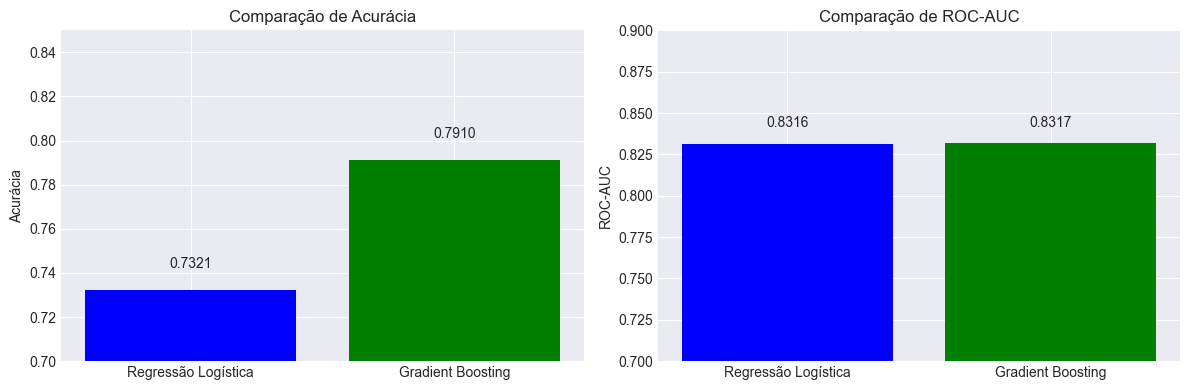

In [38]:
# Gráfico de comparação das métricas
modelos = ['Regressão Logística', 'Gradient Boosting']
acuracia = [modelo_lr_melhorado.score(X_test_scaled, y_test), 
            modelo_gb_balanceado.score(X_test_scaled, y_test)]
roc_auc = [roc_auc_score(y_test, y_pred_proba_lr_mel),
           roc_auc_score(y_test, y_pred_proba_gb_bal)]

fig, ax = plt.subplots(1, 2, figsize=(12, 4))

# Acurácia
ax[0].bar(modelos, acuracia, color=['blue', 'green'])
ax[0].set_ylabel('Acurácia')
ax[0].set_title('Comparação de Acurácia')
ax[0].set_ylim([0.7, 0.85])
for i, v in enumerate(acuracia):
    ax[0].text(i, v + 0.01, f'{v:.4f}', ha='center')

# ROC-AUC
ax[1].bar(modelos, roc_auc, color=['blue', 'green'])
ax[1].set_ylabel('ROC-AUC')
ax[1].set_title('Comparação de ROC-AUC')
ax[1].set_ylim([0.7, 0.9])
for i, v in enumerate(roc_auc):
    ax[1].text(i, v + 0.01, f'{v:.4f}', ha='center')

plt.tight_layout()
plt.show()

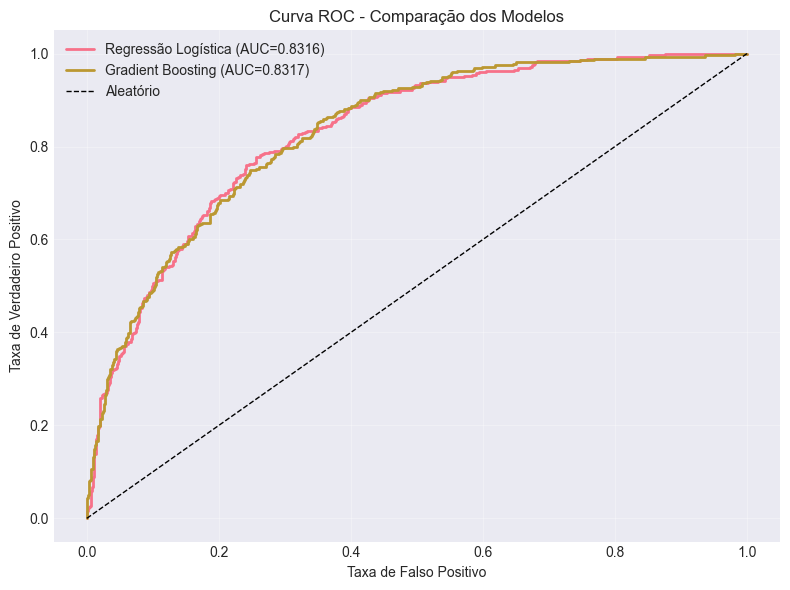

In [39]:
# Gráfico 1: Curva ROC
from sklearn.metrics import roc_curve

fpr_lr, tpr_lr, _ = roc_curve(y_test, y_pred_proba_lr_mel)
fpr_gb, tpr_gb, _ = roc_curve(y_test, y_pred_proba_gb_bal)

fig, ax = plt.subplots(figsize=(8, 6))

ax.plot(fpr_lr, tpr_lr, label=f'Regressão Logística (AUC={roc_auc_score(y_test, y_pred_proba_lr_mel):.4f})', linewidth=2)
ax.plot(fpr_gb, tpr_gb, label=f'Gradient Boosting (AUC={roc_auc_score(y_test, y_pred_proba_gb_bal):.4f})', linewidth=2)
ax.plot([0, 1], [0, 1], 'k--', label='Aleatório', linewidth=1)

ax.set_xlabel('Taxa de Falso Positivo')
ax.set_ylabel('Taxa de Verdadeiro Positivo')
ax.set_title('Curva ROC - Comparação dos Modelos')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

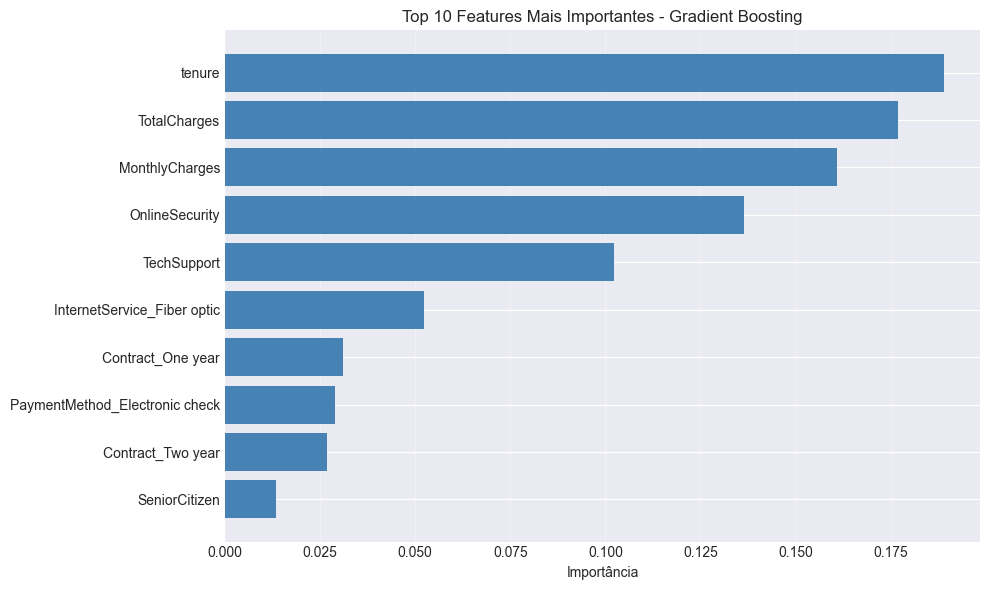

In [40]:
# Gráfico 2: Feature Importance do Gradient Boosting
importancia = modelo_gb_balanceado.feature_importances_
features = X_train_scaled.columns

# Ordenar e pegar as 10 mais importantes
indices = np.argsort(importancia)[-10:]
features_top = [features[i] for i in indices]
importancia_top = importancia[indices]

fig, ax = plt.subplots(figsize=(10, 6))

ax.barh(features_top, importancia_top, color='steelblue')
ax.set_xlabel('Importância')
ax.set_title('Top 10 Features Mais Importantes - Gradient Boosting')
ax.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

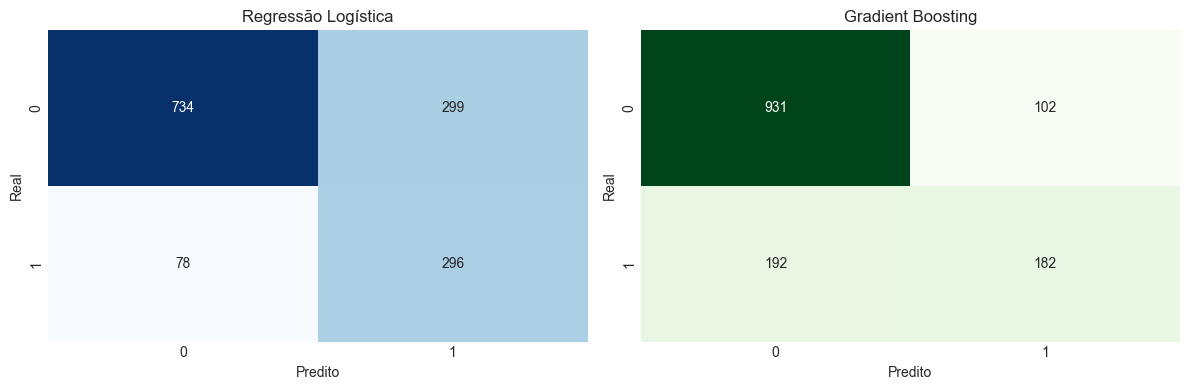

In [41]:
# Matrizes de confusão
cm_lr = confusion_matrix(y_test, y_pred_lr_mel)
cm_gb = confusion_matrix(y_test, y_pred_gb_bal)

fig, ax = plt.subplots(1, 2, figsize=(12, 4))

# Regressão Logística
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues', ax=ax[0], cbar=False)
ax[0].set_title('Regressão Logística')
ax[0].set_ylabel('Real')
ax[0].set_xlabel('Predito')

# Gradient Boosting
sns.heatmap(cm_gb, annot=True, fmt='d', cmap='Greens', ax=ax[1], cbar=False)
ax[1].set_title('Gradient Boosting')
ax[1].set_ylabel('Real')
ax[1].set_xlabel('Predito')

plt.tight_layout()
plt.show()

# 9. Conclusion

## Resumo do Projeto

- Foi analisado cerda de 7.032 dados de clientes de uma operadora de telecomunicações para prever quem tem risco de cancelar o serviço.

## Utilização de 2 Modelos

1. **Regressão Logística**: 73,21% de acurácia, ROC-AUC 0,8316
2. **Gradient Boosting**: 79,10% de acurácia, ROC-AUC 0,8317

O Gradient Boosting foi escolhido como melhor modelo.

## Principais Insights

**Fatores que aumentam o risco de churn:**
- Internet por fibra óptica (correlação: 0,31)
- Pagamento por cheque eletrônico (correlação: 0,30)
- Custos mensais altos (média de churn: R$ 74,44 vs R$ 61,31)

**Fatores que reduzem o risco de churn:**
- Tempo de cliente (tenure): -0,35 de correlação
- Contrato de 2 anos: -0,30 de correlação
- Ter segurança online: -0,28 de correlação
- Ter suporte técnico: -0,27 de correlação

## Recomendações 

- Focar em retenção nos primeiros meses do cliente
- Oferecer contratos mais longos com incentivos mais chamativos
- Promover serviços de segurança e suporte para aumentar lealdade
- Revisar precificação para clientes com custos altos
- Investigar problemas de satisfação em internet fibra

## Performance Final

- O modelo Gradient Boosting identifica 49% dos clientes em risco de churn
- Com 64% de precisão nessas predições
- ROC-AUC de 0,8317 indica boa capacidade discriminativa